In [ ]:
import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import json

In [ ]:
directory = '../eodata/sentinel5p/no2/'
os.chdir(directory)


In [ ]:
from ipynb.fs.full.ltpy_functions import visualize_s5p_pcolormesh, generate_masked_array, generate_geographical_subset


### Create file list of `tiffs`

In [21]:
fileList = glob.glob('*.tif')
fileList

['S5P_OFFL_L3__NO2____20181103_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181017_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181102_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181018_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181104_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181019_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181105_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181020_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181106_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181021_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL

In [ ]:
conversion_factor=6.02214*1e+19

In [ ]:
# Data visualization units.
unit = '*1e-15 mol/cm-2'

# This is this title of the graph that will appear below.
longname = 'Tropospheric vertical column of nitrogen dioxide (NO2)'

In [ ]:
eur_extent={'name': 'eur_extent',
    'lonmin':-10.0,
            'lonmax':30.0,
            'latmin':35.0,
            'latmax':60.0}

# Italy (Po Valley, Milano)
povalley_extent={'name': 'povalley_extent',
    'lonmin':7.0,
            'lonmax':13.0,
            'latmin':44.0,
            'latmax':47.0}



# China (Hubei, Wuhan)
hubei_extent={'name': 'hubei_extent',
    'lonmin':108.3,
            'lonmax':116.1,
            'latmin':29.1,
            'latmax':33.3}


region_list =[eur_extent,
             povalley_extent,
             hubei_extent]

#London / Paris / Hubei / FFM / Milan, New York
#Macro areas Benelux, Ruhr-Rhine, Po Valley, Poland, Wider China, Eastern Coast
#Use the same definitions for GOME2 for Macro areas to compare datasets

In [31]:
fileList_sort = sorted(fileList)
fileList_sort[15:196]

['S5P_OFFL_L3__NO2____20181101_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181102_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181103_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181104_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181105_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181106_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181107_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181108_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181109_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL_L3__NO2____20181110_PRODUCT_daily_nitrogendioxide_tropospheric_column_mask75_4326.tif',
 'S5P_OFFL

## Binning with xarray

### Generate daily xarray NetCDF files on a regular grid with 0.036 deg resolution

In [32]:
lat_bins = np.arange(-90,90+(0.036/2),0.036)
lon_bins = np.arange(-180,180+(0.036/2), 0.036)

# define a label for each bin corresponding to the central latitude
lat_center = np.arange(-90+(0.036/2),90,0.036)
lon_center = np.arange(-180+(0.036/2),180,0.036)

for i in range(15,196):
        print(i)
        tmp = xr.open_rasterio(fileList_sort[i])
        tmp_name = fileList_sort[i].split('_')[8]
        print(tmp_name)
        tmp= tmp.rename({'x': 'lon', 'y':'lat'})

        tmp_flag = tmp.where(tmp>0,np.nan)
        

        tmp_regrid_lat = tmp_flag.groupby_bins('lat', lat_bins, labels=lat_center).mean()
        tmp_regrid = tmp_regrid_lat.groupby_bins('lon', lon_bins, labels=lon_center).mean()
        tmp_regrid

        data_array = xr.DataArray(
                tmp_regrid.isel(band=0).values,
                dims=['lat','lon'],
                coords={
                    'time': pd.to_datetime(tmp_name),
                    'lat':(['lat'],tmp_regrid.isel(band=0).lat_bins),
                    'lon':(['lon'],tmp_regrid.isel(band=0).lon_bins)
                },
                attrs={'long_name': longname, 'units': unit},
                name='NO2_tropo'
            )
        


        data_array.to_netcdf('./nc/2019/s5p_no2_'+tmp_name+'.nc', 'w')  

15
20181101
16
20181102
17
20181103
18
20181104
19
20181105
20
20181106
21
20181107
22
20181108
23
20181109
24
20181110
25
20181111
26
20181112
27
20181113
28
20181114
29
20181115
30
20181116
31
20181117
32
20181118
33
20181119
34
20181120
35
20181121
36
20181122
37
20181123
38
20181124
39
20181125
40
20181126
41
20181127
42
20181128
43
20181129
44
20181130
45
20181201
46
20181202
47
20181203
48
20181204
49
20181205
50
20181206
51
20181207
52
20181208
53
20181209
54
20181210
55
20181211
56
20181212
57
20181213
58
20181214
59
20181215
60
20181216
61
20181217
62
20181218
63
20181219
64
20181220
65
20181221
66
20181222
67
20181223
68
20181224
69
20181225
70
20181226
71
20181227
72
20181228
73
20181229
74
20181230
75
20181231
76
20190101
77
20190102
78
20190103
79
20190104
80
20190105
81
20190106
82
20190107
83
20190108
84
20190109
85
20190110
86
20190111
87
20190112
88
20190113
89
20190114
90
20190115
91
20190116
92
20190117
93
20190118
94
20190119
95
20190120
96
20190121
97
20190122
98
2

### Load regular gridded NetCDF files and retrieve NO2 tropo parameter for NDJFMA 2019 and 2020

In [33]:
ndjfma_2019 = xr.open_mfdataset('./nc/2019/s5p*', concat_dim='time')
no2_tropo_2019=ndjfma_2019.NO2_tropo
no2_tropo_2019

ndjfma_2020 = xr.open_mfdataset('./nc/2020/s5p*', concat_dim='time')
no2_tropo_2020=ndjfma_2020.NO2_tropo
no2_tropo_2020


<xarray.DataArray 'NO2_tropo' (time: 169, lat: 5000, lon: 10000)>
dask.array<concatenate, shape=(169, 5000, 10000), dtype=float32, chunksize=(1, 5000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.98 -89.95 -89.91 -89.87 ... 89.91 89.95 89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2019-11-01 2019-11-02 ... 2020-04-17
Attributes:
    long_name:  Tropospheric vertical column of nitrogen dioxide (NO2)
    units:      *1e-15 mol/cm-2

### Resample data and generate monthly means

In [34]:
no2_monthly_2019 = no2_tropo_2019.resample(time='M',skipna=False).mean()
no2_monthly_2020 = no2_tropo_2020.resample(time='M',skipna=False).mean()
no2_monthly_2020 = no2_monthly_2020*conversion_factor
no2_monthly_2019 = no2_monthly_2019*conversion_factor
no2_monthly_2020

<xarray.DataArray 'NO2_tropo' (time: 6, lat: 5000, lon: 10000)>
dask.array<mul, shape=(6, 5000, 10000), dtype=float32, chunksize=(1, 5000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-11-30 2019-12-31 ... 2020-04-30
  * lat      (lat) float64 -89.98 -89.95 -89.91 -89.87 ... 89.91 89.95 89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0

In [ ]:
def generate_geographical_subset(xarray, latmin, latmax, lonmin, lonmax):
    """ 
    Generates a geographical subset of a xarray DataArray and shifts the longitude grid from a 0-360 to a -180 to 180 deg grid.
    
    Parameters:
        xarray (xarray DataArray): a xarray DataArray with latitude and longitude coordinates
        latmin, latmax, lonmin, lonmax (int): boundaries of the geographical subset
        
    Returns:
        Geographical subset of a xarray DataArray.
    """   
    return xarray.where((xarray.lat < latmax) & (xarray.lat > latmin) & (xarray.lon < lonmax) & (xarray.lon > lonmin),drop=True)

In [35]:
region = region_list[0]

eur20 = generate_geographical_subset(no2_monthly_2020,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
eur19 = generate_geographical_subset(no2_monthly_2019,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])

In [60]:
eur20_mean = eur20.mean({'lat','lon'})
eur20_mean

eur19_mean = eur19.mean({'lat','lon'})
eur19_mean

eur20_pd = eur20_mean.to_series()
eur19_pd = eur19_mean.to_series()

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f77510ecb00>)

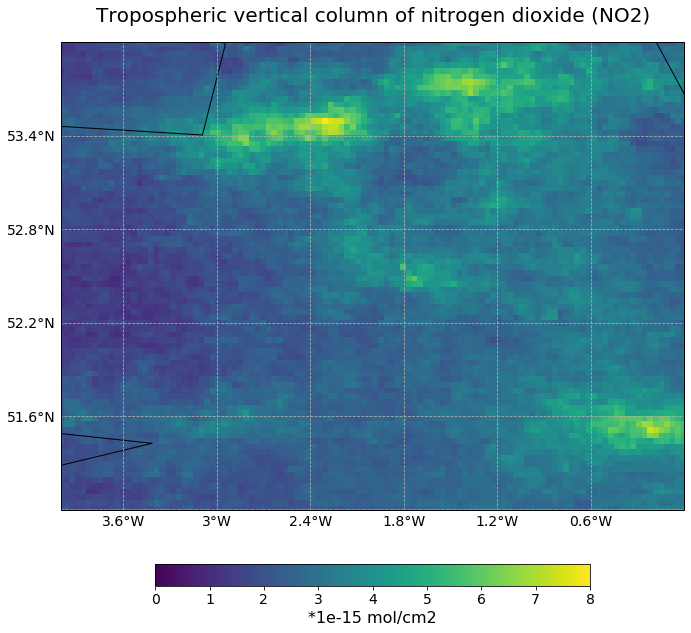

In [62]:
visualize_s5p_pcolormesh(eur20.isel(time=4)*1e-15, 
                         eur20.isel(time=4).lon, 
                         eur20.isel(time=4).lat, 
                         ccrs.PlateCarree(), 
                         'viridis', 
                         '*1e-15 mol/cm2', 
                         no2_tropo_2019.long_name, 
                         0, 8, 
                       #  region['lonmin'],
                       #  region['lonmax'],
                       #  region['latmin'],
                       #  region['latmax'],
                         -4,
                         0,
                         51,
                         54,
                         log=False, 
                         set_global=False)

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f77511a4eb8>)

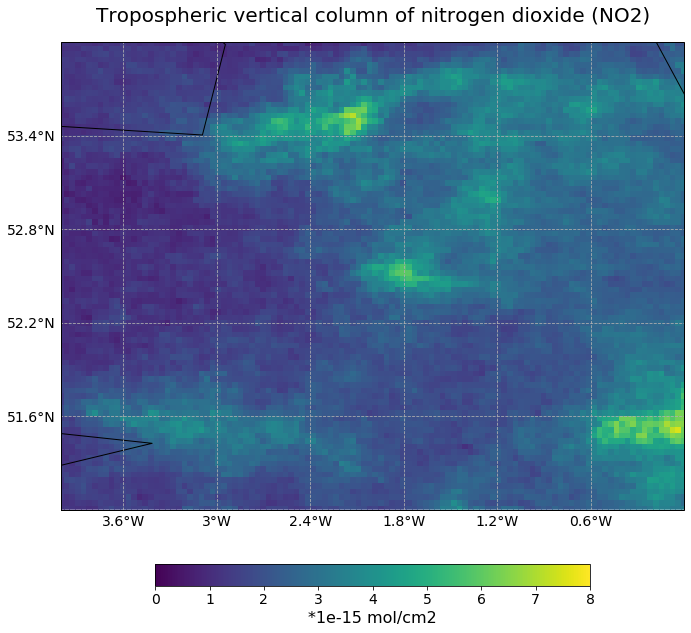

In [61]:
visualize_s5p_pcolormesh(eur19.isel(time=4)*1e-15, 
                         eur19.isel(time=4).lon, 
                         eur19.isel(time=4).lat, 
                         ccrs.PlateCarree(), 
                         'viridis', 
                         '*1e-15 mol/cm2', 
                         no2_tropo_2019.long_name, 
                         0, 8, 
                         -4,
                         0,
                         51,
                         54,
                         log=False, 
                         set_global=False)

### Generate anomaly map between Jan 2019 and Jan 2020 and Mar 2019 and 2020

In [38]:
anomaly_1920_jan = no2_monthly_2020.isel(time=2) - no2_monthly_2019.isel(time=2)
anomaly_1920_jan

anomaly_1920_mar = no2_monthly_2020.isel(time=4) - no2_monthly_2019.isel(time=4)
anomaly_1920_mar

<xarray.DataArray 'NO2_tropo' (lat: 5000, lon: 10000)>
dask.array<sub, shape=(5000, 10000), dtype=float32, chunksize=(5000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.98 -89.95 -89.91 -89.87 ... 89.91 89.95 89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0

## Select a region and visualize the anomaly map

### Europe region

In [ ]:
region = region_list[0]
region

In [39]:
eur_jan = generate_geographical_subset(anomaly_1920_jan,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
eur_mar = generate_geographical_subset(anomaly_1920_mar,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
eur_mar


<xarray.DataArray 'NO2_tropo' (lat: 695, lon: 1111)>
dask.array<where, shape=(695, 1111), dtype=float32, chunksize=(695, 1111), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35.01 35.05 35.08 35.12 ... 59.89 59.92 59.96 59.99
  * lon      (lon) float64 -9.99 -9.954 -9.918 -9.882 ... 29.86 29.9 29.93 29.97

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f788e05f588>)

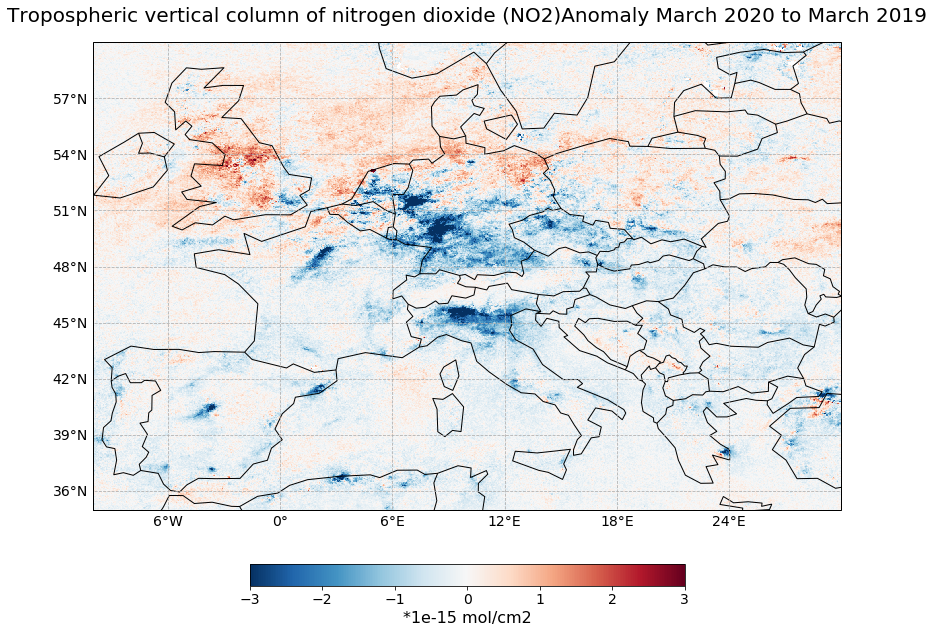

In [40]:
visualize_s5p_pcolormesh(eur_mar*1e-15, 
                         eur_mar.lon, 
                         eur_mar.lat, 
                         ccrs.PlateCarree(), 
                         'RdBu_r', 
                         '*1e-15 mol/cm2', 
                         no2_tropo_2019.long_name + 'Anomaly March 2020 to March 2019', 
                         -3, 3, 
                         region['lonmin'],
                         region['lonmax'],
                         region['latmin'],
                         region['latmax'],
                         log=False, 
                         set_global=False)

## Povalley

In [41]:
region = region_list[1]
region

povalley_jan = generate_geographical_subset(anomaly_1920_jan,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
povalley_mar = generate_geographical_subset(anomaly_1920_mar,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
povalley_mar

<xarray.DataArray 'NO2_tropo' (lat: 84, lon: 167)>
dask.array<where, shape=(84, 167), dtype=float32, chunksize=(84, 167), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 44.01 44.05 44.08 44.12 ... 46.89 46.93 46.96 47.0
  * lon      (lon) float64 7.002 7.038 7.074 7.11 ... 12.87 12.91 12.94 12.98

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f77747abda0>)

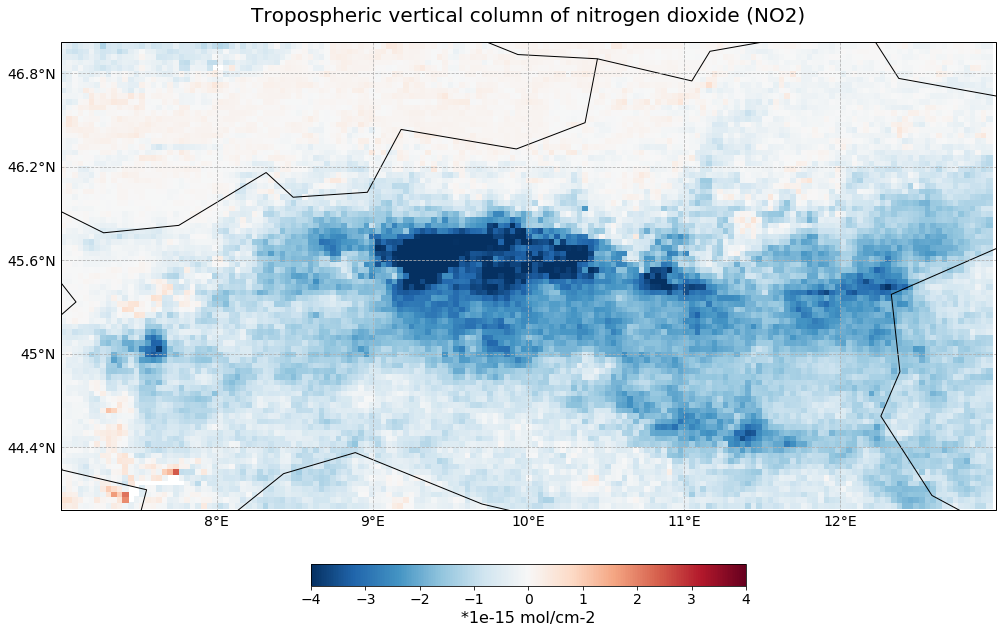

In [44]:

visualize_s5p_pcolormesh(povalley_mar*1e-15, 
                         povalley_mar.lon, 
                         povalley_mar.lat, 
                         ccrs.PlateCarree(), 
                         'RdBu_r', 
                         no2_tropo_2019.units, 
                         no2_tropo_2019.long_name, 
                         -4, 4, 
                         region['lonmin'],
                         region['lonmax'],
                         region['latmin'],
                         region['latmax'],
                         log=False, 
                         set_global=False)

### Hubei region

In [45]:
region = region_list[2]
region

hubei_jan = generate_geographical_subset(anomaly_1920_jan,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
hubei_mar = generate_geographical_subset(anomaly_1920_mar,
                                            region['latmin'],
                                            region['latmax'],
                                            region['lonmin'],
                                            region['lonmax'])
hubei_mar

<xarray.DataArray 'NO2_tropo' (lat: 117, lon: 217)>
dask.array<where, shape=(117, 217), dtype=float32, chunksize=(117, 217), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 29.11 29.14 29.18 29.21 ... 33.17 33.21 33.25 33.28
  * lon      (lon) float64 108.3 108.3 108.4 108.4 ... 116.0 116.0 116.0 116.1

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f7774397d30>)

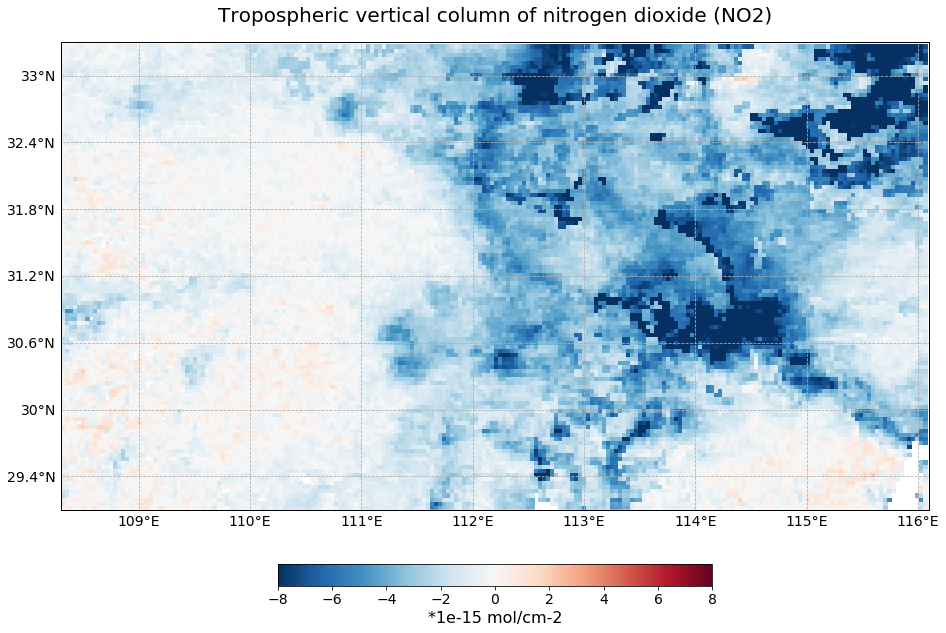

In [47]:
visualize_s5p_pcolormesh(hubei_jan*1e-15, 
                         hubei_jan.lon, 
                         hubei_jan.lat, 
                         ccrs.PlateCarree(), 
                         'RdBu_r', 
                         no2_tropo_2019.units, 
                         no2_tropo_2019.long_name, 
                         -8, 8, 
                         region['lonmin'],
                         region['lonmax'],
                         region['latmin'],
                         region['latmax'],
                         log=False, 
                         set_global=False)

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f7774327978>)

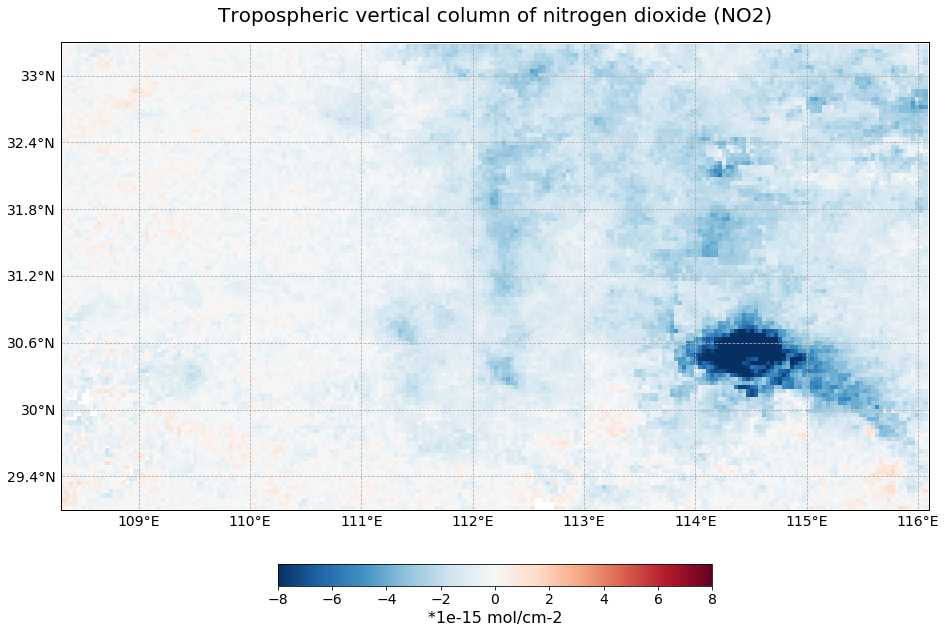

In [48]:
visualize_s5p_pcolormesh(hubei_mar*1e-15, 
                         hubei_mar.lon, 
                         hubei_mar.lat, 
                         ccrs.PlateCarree(), 
                         'RdBu_r', 
                         no2_tropo_2019.units, 
                         no2_tropo_2019.long_name, 
                         -8, 8, 
                         region['lonmin'],
                         region['lonmax'],
                         region['latmin'],
                         region['latmax'],
                         log=False, 
                         set_global=False)